<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/SequenceToSequenceExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Resource: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/
# Explaination: https://www.youtube.com/watch?v=dC_d3iVw6sc&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=114

# The encoder-decoder model provides a pattern for using recurrent neural networks to address challenging sequence-to-sequence
#  prediction problems, such as machine translation.

# After reading this, you will know:

# The neural machine translation example provided with Keras and described on the Keras blog.
# How to correctly define an encoder-decoder LSTM for training a neural machine translation model.
# How to correctly define an inference model for using a trained encoder-decoder model to translate new sequences.

# The model is applied to the problem of machine translation, the same as the source papers in which the approach was first described.
#  Technically, the model is a neural machine translation model.

# Francois’ implementation provides a template for how sequence-to-sequence prediction can be implemented (correctly) in
#  the Keras deep learning library at the time of writing.

# In this post, will take a closer look at exactly how the training and inference models were designed and how they work.

# You will be able to use this understanding to develop similar models for your own sequence-to-sequence prediction problems.

In [2]:
# Machine Translation Data
# The dataset used in the example involves short French and English sentence pairs used in the flash card software Anki.

# The dataset is called “Tab-delimited Bilingual Sentence Pairs” and is part of the Tatoeba Project and listed on the 
# ManyThings.org site for helping English as a Second Language students.

# The dataset used in the tutorial can be downloaded from here:
# http://www.manythings.org/anki/fra-eng.zip

# Below is a sample of the first 10 rows from the fra.txt data file you will see after you unzip the downloaded archive.
# Go.		Va !
# Run!	Cours !
# Run!	Courez !
# Wow!	Ça alors !
# Fire!	Au feu !
# Help!	À l'aide !
# Jump.	Saute.
# Stop!	Ça suffit !
# Stop!	Stop !
# Stop!	Arrête-toi !

# The problem is framed as a sequence prediction problem where input sequences of characters are in English and output 
# sequences of characters are in French.

# A total of 10,000 of the nearly 150,000 examples in the data file are used in the dataset. 
# Some technical details of the prepared data are as follows:

# Input Sequences: Padded to a maximum length of 16 characters with a vocabulary of 71 different characters (10000, 16, 71).
# Output Sequences: Padded to a maximum length of 59 characters with a vocabulary of 93 different characters (10000, 59, 93).
# The training data is framed such that the input for the model is comprised of one whole input sequence of English characters 
# and the whole output sequence of French characters i.e (whole english and french sentence will be used as input).
#  The output of the model is the whole sequence of French characters, 
# but offset forward by one time step.


# For example (with minimal padding and without one-hot encoding):
# Consider first sample:Go.		Va ! 

# Input1: [‘G’, ‘o’, ‘.’, '']
# Input2: [ '', ‘V’, ‘a’, ‘ ‘]
# Output: [‘V’, ‘a’, ‘ ‘, ‘!’]


In [3]:
# Machine Translation Model

# The neural translation model is an encoder-decoder recurrent neural network.

# It is comprised of an encoder that reads a variable length input sequence and a decoder that predicts a variable length output sequence.

# The model is divided into two sub-models: the encoder responsible for outputting a fixed-length encoding of the input 
# English sequence, and the decoder responsible for predicting the output sequence, one character per output time step.

# The first step is to define the encoder.
# The input to the encoder is a sequence of characters, each encoded as one-hot vectors with length of num_encoder_tokens.
# The LSTM layer in the encoder is defined with the return_state argument set to True.
#  This returns the hidden state output returned by LSTM layers generally, as well as the hidden and cell state 
#  for all cells in the layer. These are used when defining the decoder.

# encoder_inputs = Input(shape=(None, num_encoder_tokens))
# encoder = LSTM(latent_dim, return_state=True)

# encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# # We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

# Next, we define the decoder.

# The decoder input is defined as a sequence of French character one-hot encoded with a length of num_decoder_tokens.

# The LSTM layer is defined to both return sequences and state. The final hidden and cell states are ignored and 
# only the output sequence of hidden states is referenced.

# Importantly, the final hidden and cell state from the encoder is used to initialize the state of the decoder.
# This also means that the encoder and decoder LSTM layers must have the same number of cells, in this case, 256.

# A Dense output layer is used to predict each character. This Dense is used to produce each character in the output sequence
# in a one-shot manner, rather than recursively, at least during training. This is because the entire target sequence
#  required for input to the model is known during training.

# The Dense does not need to be wrapped in a TimeDistributed layer.

# Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None, num_decoder_tokens))

# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.

# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# # creating output layer
# decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# # passing the decoder_lstm to the output  layer 
# decoder_outputs = decoder_dense(decoder_outputs)

# Finally, the model is defined with inputs for the encoder and the decoder and the output target sequence.
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

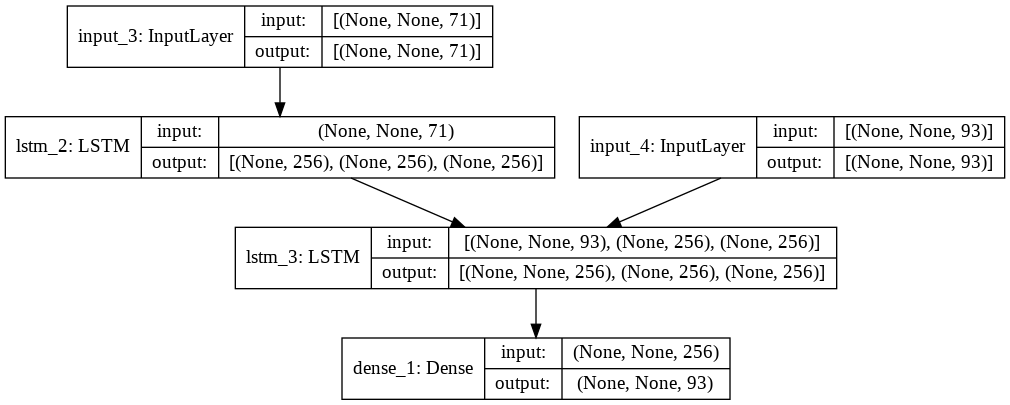

In [5]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# configure
num_encoder_tokens = 71
num_decoder_tokens = 93
latent_dim = 256

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# passing only hidden states to the dense and not the cell states
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# plot the model
plot_model(model, to_file='encoder_decoder.png', show_shapes=True)

In [6]:
# Note that the encoder LSTM does not directly pass its outputs as inputs to the decoder LSTM; as noted above, 
# the decoder uses the final hidden and cell states as the initial state for the decoder.

# Also note that the decoder LSTM only passes the sequence of hidden states to the Dense for output, 
# not the final hidden and cell states as suggested by the output shape information.